In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

style_file = os.path.expandvars('$I3_SRC/LeptonInjector/python/hnl_mpl_plotstyle.mplstyle')
plt.style.use('../ultrasurfaces_plotstyle.mplstyle')

from generator import Response
from generator import OscPars
from generator import Generator

### Plotting utility

In [2]:
def add_hist(fig, hist, label, **kwargs):
    # first and last bin are overflow bins in hist
    plt.stairs(hist['hist'][1:-1], hist['bin_edges'], label=label, **kwargs, lw=2.5)
    plt.stairs(
        hist['hist'][1:-1] + hist['hist_unc'][1:-1],
        hist['bin_edges'],
        baseline=hist['hist'][1:-1] - hist['hist_unc'][1:-1],
        fill=True,
        alpha=0.5,
        **kwargs
    )

### Set standard parameters

In [3]:
delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = OscPars(delta_msq_31, sinsq_2theta_23)

default_response = Response(1., 0.05)

bin_edges = np.logspace(1., 2., 26)

## Check event generation

### Just playing around with a couple of histograms

In [4]:
gen = Generator(int(1e5), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


In [5]:
gen_2 = Generator(int(1e5), default_response, OscPars(1.2 * default_pars.delta_mqs, default_pars.sinsq_2theta))
h2 = gen_2.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


In [6]:
gen_3 = Generator(int(1e5), Response(1.2 * default_response.mu, default_response.sigma), default_pars)
h3 = gen_3.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


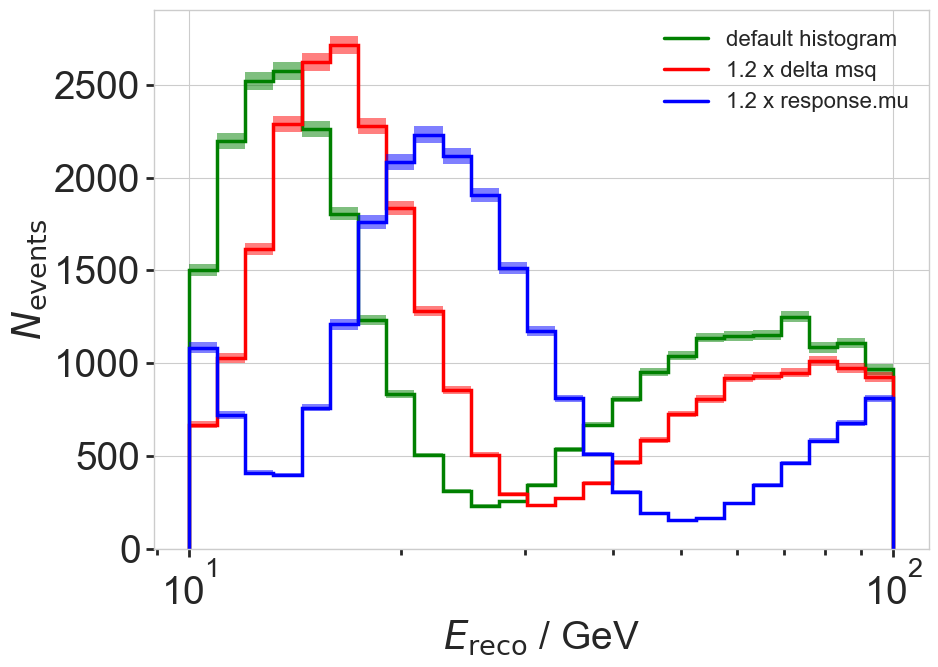

In [7]:
fig = plt.figure()

add_hist(fig, h0, 'default histogram', color='g')

add_hist(fig, h2, '1.2 x delta msq', color='r')

add_hist(fig, h3, '1.2 x response.mu', color='b')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

## Toy analysis

### Define systematic sets by their detector response, assuming the default oscillation parameters for now

In [8]:
default_response = Response(1., 0.05)
nevents = int(1e5)

In [9]:
variations = {
    'mu': {
        'baseline': 1.,
        'up': 1.05,
        'low': 0.95,
    }
}

responses = {
    "mu_baseline": Response(variations['mu']['baseline'] * default_response.mu, default_response.sigma),
    "mu_up": Response(variations['mu']['up'] * default_response.mu, default_response.sigma),
    "mu_low": Response(variations['mu']['low'] * default_response.mu, default_response.sigma),
}

# assume default oscillation parameters for now
sets = {k: Generator(nevents, r, default_pars) for k,r in responses.items()}



Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


In [10]:
variations

{'mu': {'baseline': 1.0, 'up': 1.05, 'low': 0.95}}

In [11]:
sets

{'mu_baseline': <generator.Generator at 0x7f179c3ec9d0>,
 'mu_up': <generator.Generator at 0x7f179c3dfa90>,
 'mu_low': <generator.Generator at 0x7f179c3df820>}

### Use the discrete sets, so far only gradients in $\mu$ are calculated for testing

In [12]:
class ToyAnalysis():

    def __init__(self, sets, variations, binning) -> None:

        self.__sets = sets

        self.__binning = binning

        # pick one of the baseline sets
        self.__baseline_set = [s for k, s in sets.items() if "baseline" in k][0]

        self.__baseline_reponse = self.__baseline_set.get_detector_response()
        self.__default_pars = self.__baseline_set.get_oscillation_pars()

        self.__make_gradients(variations)

    def __make_gradients(self, variations):

        gradients_histogram = {}
        # naive way of calculating finite difference: G = (hist_up - hist_low) / delta_par
        # TODO: include statistical uncertainties?
        for par, vals in variations.items():
            
            hist_up = self.__sets[par+'_up'].get_histogram(self.__binning)['hist']
            hist_low = self.__sets[par+'_low'].get_histogram(self.__binning)['hist']
            delta_par = vals['up'] - vals['low']

            gradients_histogram[par] = (hist_up - hist_low) / delta_par

        self.__gradients = gradients_histogram
        
    def get_histogram(self, response, osc_pars):
        # reweight baseline set to oscillation parameters
        self.__baseline_set.reweight_oscillation(osc_pars)
        hist_base = self.__baseline_set.get_histogram(self.__binning)['hist']
        hist_base_unc = self.__baseline_set.get_histogram(self.__binning)['hist_unc']

        # not strictly necessary: re-set generator of baseline set to default oscillation pars
        self.__baseline_set.reweight_oscillation(self.__default_pars)

        # apply gradients:
        print("Warning: Only gradients with respect to 'mu' are implemeted so far")
        # TODO otherwise: loop over parameters...
        hist_final = hist_base + (response.mu - self.__baseline_reponse.mu) * self.__gradients['mu']

        # return histogram in full format (see Generator), statistical uncertainties from gradients not yet included...
        return {'hist': hist_final, 'hist_unc': hist_base_unc, 'bin_edges': self.__binning}

In [13]:
analysis = ToyAnalysis(sets, variations, bin_edges)

## Compare target histograms for generated set and gradient approximation:

### Default oscillation parameters

In [14]:
target_response = Response(1.05 * default_response.mu, default_response.sigma)
target_pars = OscPars(1. * default_pars.delta_mqs, default_pars.sinsq_2theta)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


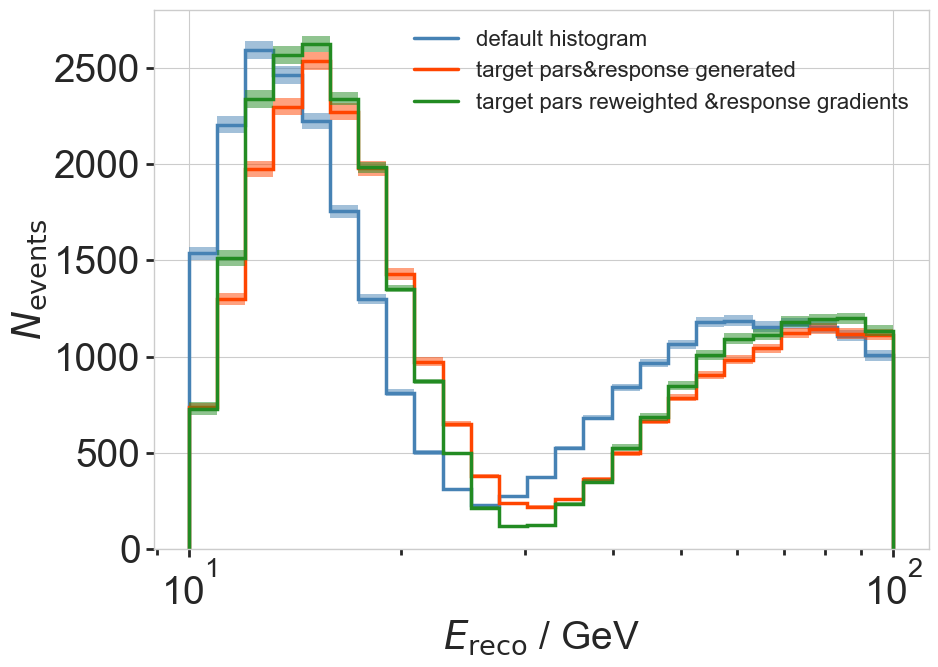

In [15]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='orangered')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='forestgreen')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

### Non-default oscillation parameters: larger mass splitting

In [16]:
target_response = Response(1.05 * default_response.mu, default_response.sigma)
target_pars = OscPars(1.3 * default_pars.delta_mqs, default_pars.sinsq_2theta)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


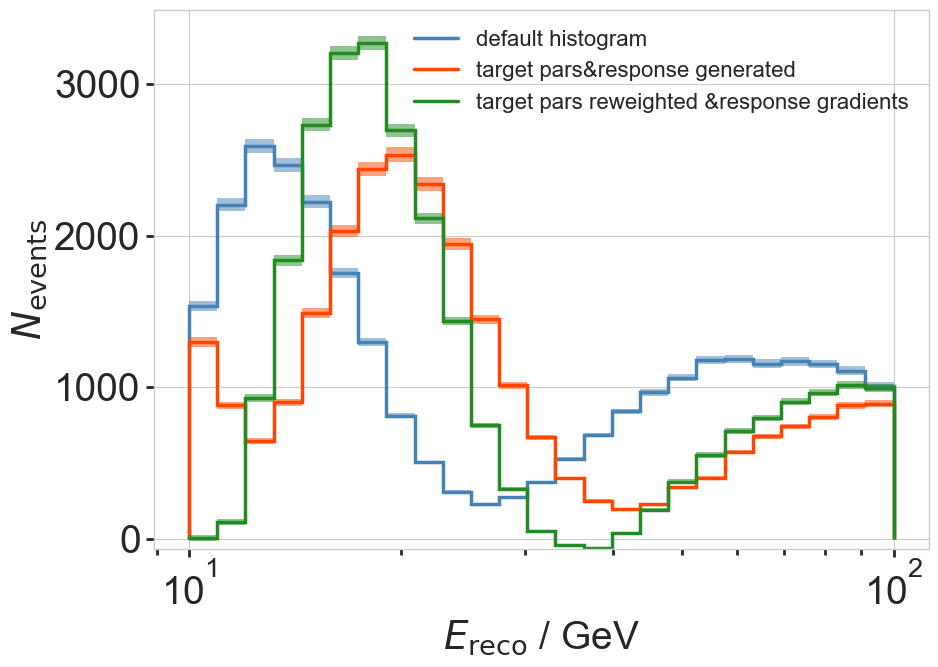

In [17]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='orangered')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='forestgreen')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

#### Set up dataset to train KNN

In [18]:
sets

{'mu_baseline': <generator.Generator at 0x7f179c3ec9d0>,
 'mu_up': <generator.Generator at 0x7f179c3dfa90>,
 'mu_low': <generator.Generator at 0x7f179c3df820>}

In [19]:
[sys_set_key for sys_set_key, sys_set in sets.items() if sys_set_key != 'mu_baseline']

['mu_up', 'mu_low']

In [20]:
X_nom = np.vstack((
    sets['mu_baseline'].get_events()["true_energy"],
    sets['mu_baseline'].get_events()["reco_energy"]
)).T

weights_nom = sets['mu_baseline'].get_events()["weights"]

X_sys = [
    np.vstack((sys_set.get_events()["true_energy"],
               sys_set.get_events()["reco_energy"]
              )).T
    for sys_set_key, sys_set in sets.items() if sys_set_key != 'mu_baseline'
]

weights_sys = np.hstack([
    sys_set.get_events()["weights"]
    for sys_set_key, sys_set in sets.items() if sys_set_key != 'mu_baseline'
])

X = np.vstack([X_nom] + X_sys)

weights = np.hstack([weights_nom] + [weights_sys])

y = np.hstack(
    [
        np.full(len(sets['mu_baseline'].get_events()["true_energy"]), i)
        for i, _ in enumerate(sets)
    ]
)

# print(X[:10])
# print(y[:10])

# after n * nevents it switches between sets
n = 1
# print(y[n*nevents-5:n*nevents+5])
n = 2
# print(y[n*nevents-5:n*nevents+5])

In [21]:
from generator import create_histogram

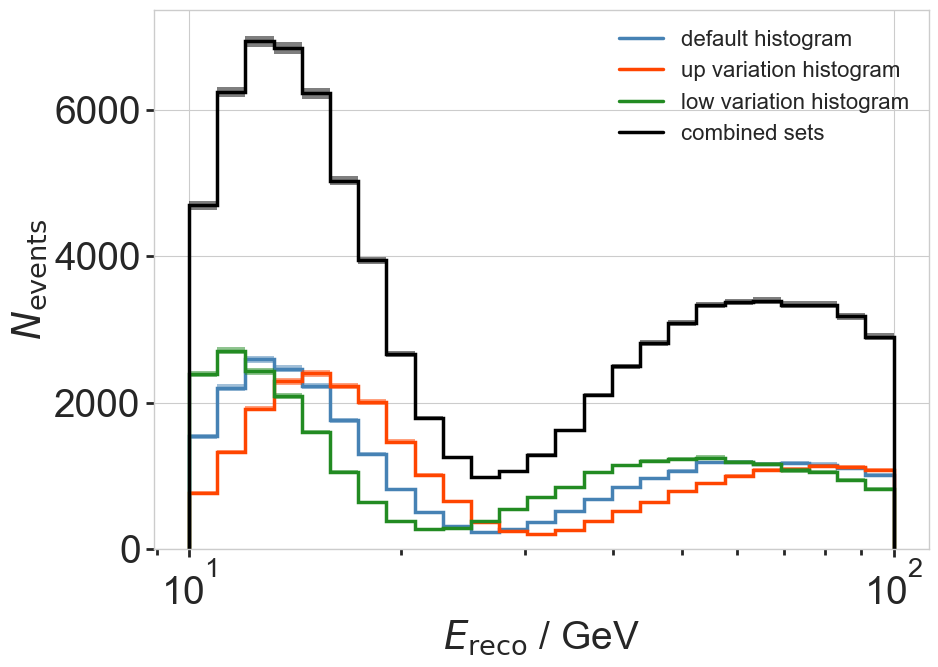

In [22]:
# look at the full reco data

fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, sets['mu_up'].get_histogram(bin_edges),
    'up variation histogram', color='orangered')

add_hist(fig, sets['mu_low'].get_histogram(bin_edges),
    'low variation histogram', color='forestgreen')

add_hist(fig, create_histogram(X[:,1], weights, bin_edges),
    'combined sets', color='k')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

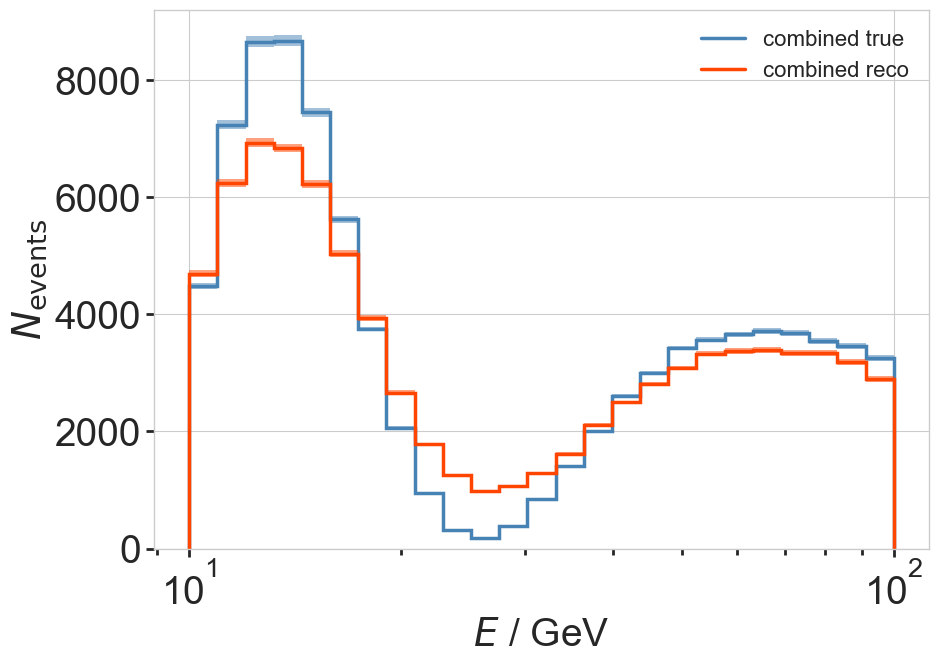

In [23]:
# look at reco/true data (fed into the classifier)

fig = plt.figure()

add_hist(fig, create_histogram(X[:,0], weights, bin_edges),
    'combined true', color='steelblue')

add_hist(fig, create_histogram(X[:,1], weights, bin_edges),
    'combined reco', color='orangered')

plt.xscale('log')
plt.xlabel(r'$E$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

#### Set up the KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# a transformer to make all of the input data normal... classifiers like this
trafo = preprocessing.PowerTransformer(method='box-cox', standardize=True)

In [25]:
X_transformed = trafo.fit_transform(X)

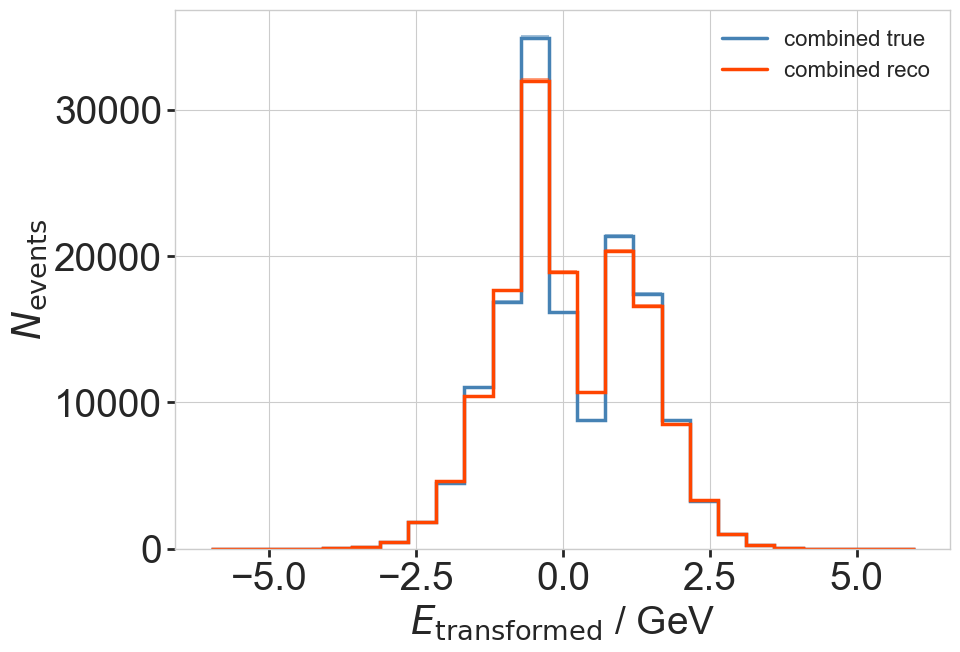

In [26]:
# look at transformed reco/true data (fed into the classifier)

fig = plt.figure()

bin_edges_transformed = np.linspace(-6., 6., 26)

add_hist(fig, create_histogram(X_transformed[:,0], weights, bin_edges_transformed),
    'combined true', color='steelblue')

add_hist(fig, create_histogram(X_transformed[:,1], weights, bin_edges_transformed),
    'combined reco', color='orangered')

# plt.xscale('log')
plt.xlabel(r'$E_{\rm transformed}$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

In [27]:
knn = KNeighborsClassifier(n_neighbors=1000, weights="uniform")
pipe = Pipeline(
    [("transform", trafo), ("classifier", knn)]
)
pipe.fit(X, y)

Pipeline(steps=[('transform', PowerTransformer(method='box-cox')),
                ('classifier', KNeighborsClassifier(n_neighbors=1000))])

### Use predictions to re-weight nominal set

In [28]:
nominal_set_probabilities = pipe.predict_proba(X_nom)

In [29]:
# systematic set to be emulated
set_nr = 1

# calculate the denominator of the ratio
posterior_nominal = nominal_set_probabilities[:, 0]

# calculate the nominator
posterior_sys = nominal_set_probabilities[:, set_nr]

# adjust weights (but don't change the initial weights so we don't have to re-create the model)

weights_nom_KNN_rescaled = weights_nom * posterior_sys / posterior_nominal

In [30]:
target_response = Response(1.05 * default_response.mu, default_response.sigma)  # use "up" variation
target_pars = OscPars(1.2 * default_pars.delta_mqs, default_pars.sinsq_2theta)

print(target_response)
print(target_pars)



Response(mu=1.05, sigma=0.05)
OscPars(delta_mqs=0.003018, sinsq_2theta=0.9831000000000002)


Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


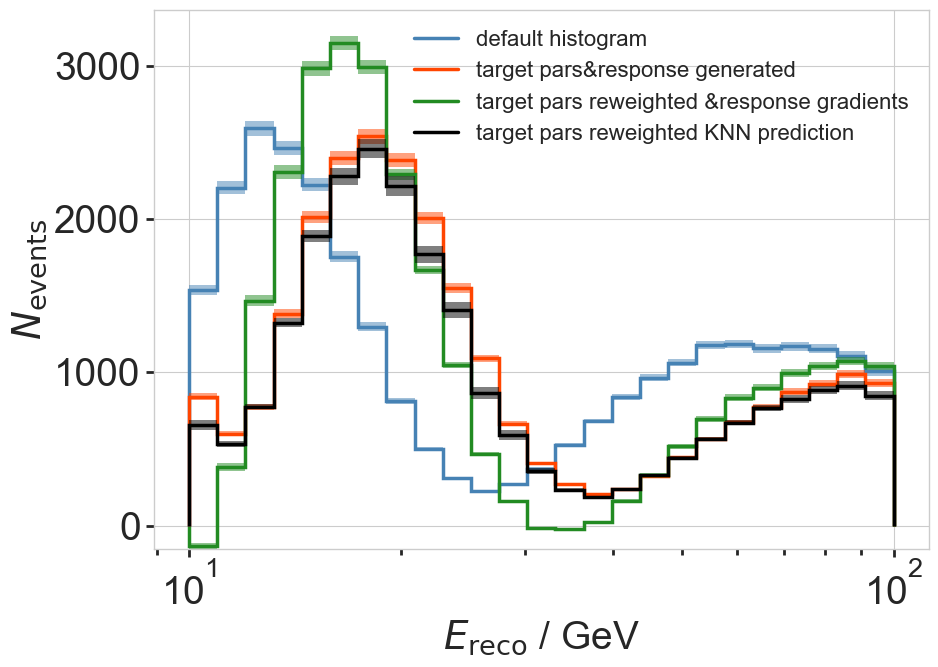

In [31]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='orangered')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='forestgreen')

add_hist(fig, create_histogram(X_nom[:,1], weights_nom_KNN_rescaled * sets['mu_baseline'].get_oscillation_reweight_factor(target_pars), bin_edges),
    'target pars reweighted KNN prediction', color='k')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()